In [23]:
import pandas as pd
import numpy as np
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Initial processing and helper functions

In [24]:
PATH = Path('data/PASCAL_VOC/')
# list(PATH.iterdir())

train_json = json.load((PATH/'pascal_train2007.json').open())
train_json.keys()

IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
train_json[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}]

In [25]:
train_json[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [26]:
train_json[CATEGORIES][:2]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'}]

In [27]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {cat[ID]:cat['name'] for cat in train_json[CATEGORIES]}
train_file_name = {im[ID]:im[FILE_NAME] for im in train_json[IMAGES]}
train_ids = [im[ID] for im in train_json[IMAGES]]

list((PATH/'VOCdevkit'/'VOC2007').iterdir())
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS
print(list(IMG_PATH.iterdir())[:5])
img0 = train_json[IMAGES][15]
img0[FILE_NAME], img0[ID], img0['height'], img0['width']

[PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/007594.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/005866.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/007013.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/005682.jpg'), PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/000080.jpg')]


('000066.jpg', 66, 375, 500)

In [28]:
[{ann[IMG_ID]:[ann[BBOX]]} for ann in train_json[ANNOTATIONS] if ann[IMG_ID]==47][0]

{47: [[14, 0, 445, 312]]}

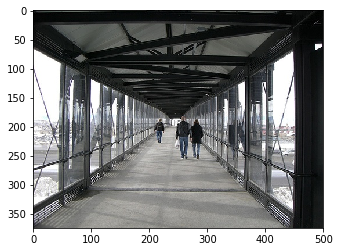

In [29]:
plt.imshow(open_image(IMG_PATH/img0[FILE_NAME]))

In [30]:
def top_left_bottom_right(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_original(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])


In [31]:
train_anno = collections.defaultdict(lambda:[])
for ann in train_json[ANNOTATIONS]:
    if not ann['ignore']:
        bb = ann[BBOX]
        bb = top_left_bottom_right(bb)
        train_anno[ann[IMG_ID]].append((bb, ann[CAT_ID]))

print(len(train_anno))
train_anno[img0[ID]]      

2501


[(array([186, 208, 229, 227]), 15),
 (array([181, 241, 258, 273]), 15),
 (array([187, 268, 258, 294]), 15)]

In [32]:
im = open_image(IMG_PATH/img0[FILE_NAME])

In [33]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [34]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_original(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = train_anno[i]
    im = open_image(IMG_PATH/train_file_name[i])
    print(im.shape)
    draw_im(im, im_a)

### Multiple Classes

In [35]:
MC_CSV = PATH/'tmp/mc.csv'

In [36]:
train_anno[66]

[(array([186, 208, 229, 227]), 15),
 (array([181, 241, 258, 273]), 15),
 (array([187, 268, 258, 294]), 15)]

In [37]:
mc = [set([cats[j[1]] for j in train_anno[i]]) for i in train_ids]
mcs = [' '.join(str(j) for j in m) for m in mc]
mcs[0:5]

['car', 'horse person', 'bicycle person', 'car', 'aeroplane person']

In [38]:
df = pd.DataFrame({'filename': [train_file_name[ti] for ti in train_ids], 'classes': mcs}, columns=['filename','classes'])
df.to_csv(MC_CSV, index=False)

In [39]:
df.head()

filename           classes
0  000012.jpg               car
1  000017.jpg      horse person
2  000023.jpg    bicycle person
3  000026.jpg               car
4  000032.jpg  aeroplane person

### Class detection

In [40]:
f_model = resnet34
sz = 224
bs = 66

In [41]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms)

In [43]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [44]:
lrf=learn.lr_find(1e-5,10)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.121452   12.85625   0.5345    



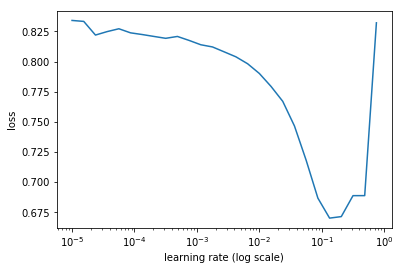

In [45]:
learn.sched.plot(0)

In [46]:
lr = 2e-2

In [47]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.320342   0.149371   0.9501    
    1      0.172869   0.079583   0.9747                    
    2      0.115043   0.077277   0.9739                    



[array([0.07728]), 0.9738999981880188]

In [48]:
lrs = np.array([lr/100, lr/10, lr])

In [49]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:16<00:03,  1.64it/s, loss=0.449] 

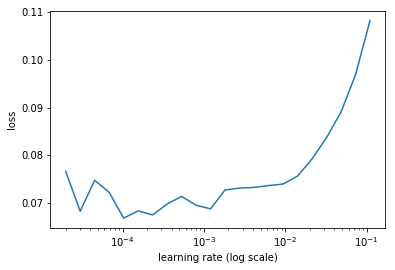

In [50]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [51]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                     


Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   <lambda>                   
    0      0.071652   0.08309    0.9709    
    1      0.052841   0.076303   0.9751                     
    2      0.03795    0.074355   0.9766                     
    3      0.027351   0.074318   0.9764                     
    4      0.019631   0.074257   0.9768                     



[array([0.07426]), 0.9768000073432922]

In [52]:
learn.save('mclas')
learn.load('mclas')

In [53]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

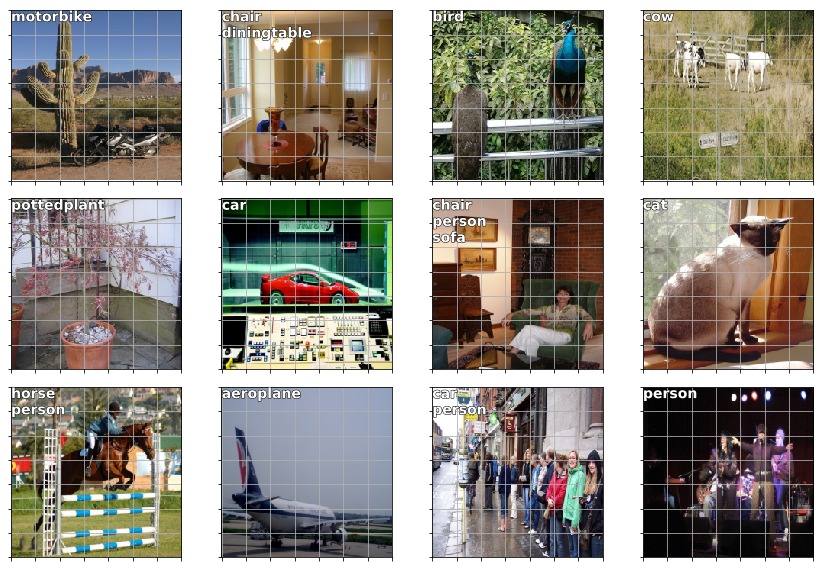

In [54]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i+6]
    ya = np.nonzero(y[i+6]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

### Bounding box preprocessing

In [55]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

In [56]:
mc = [[cats[p[1]] for p in train_anno[ti]] for ti in train_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [57]:
val_idxs = get_cv_idxs(len(train_file_name))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [59]:
mbb = [np.concatenate([p[0] for p in train_anno[ti]]) for ti in train_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'filename': [train_file_name[ti] for ti in train_ids], 'bbox': mbbs}, columns=['filename','bbox'])
df.to_csv(MBB_CSV, index=False)

In [60]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [61]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [63]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [top_left_bottom_right(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [64]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [65]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [66]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [67]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

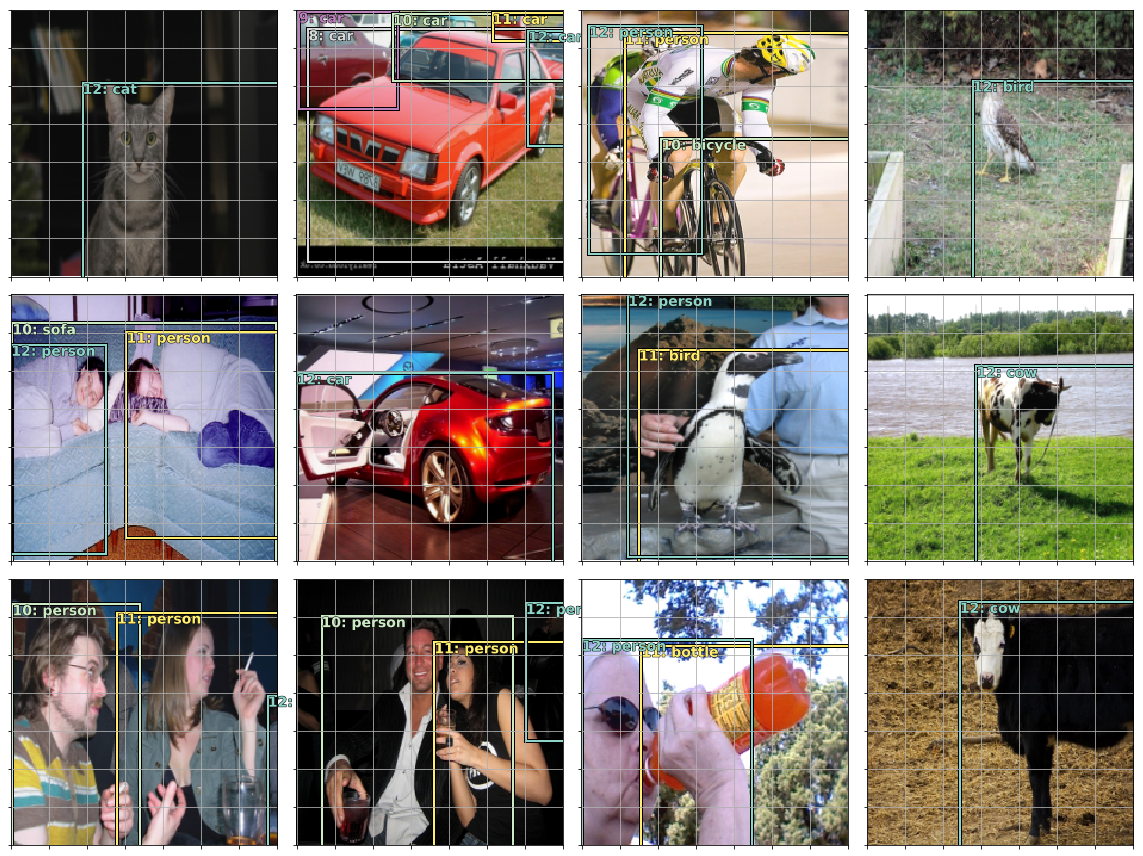

In [68]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

### Predict only the object in a given bb

In [121]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [122]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

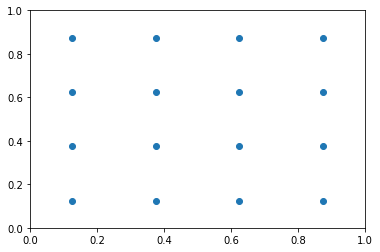

In [123]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [124]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [125]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [126]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [127]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [128]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [129]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [130]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

### Training

In [131]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [132]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [133]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [134]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [135]:
for i,o in enumerate(y): y[i] = o
learn.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [136]:
batch = learn.model(x)

In [137]:
anchors = anchors; grid_sizes = grid_sizes; anchor_cnr = anchor_cnr

In [138]:
ssd_loss(batch, y, True)


 0.1947
 0.1168
 0.2652
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2885
 0.0888
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.9027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.1608
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3237
 0.2153
 0.2558
 0.2013
 0.2526
 0.0485
 0.0879
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3258
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2704
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.4538
 0.1897
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.1527
 0.1863
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3249
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.0642
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2418
 0.2337
 0.2590
[torch.cuda.FloatTensor of size 3 (GPU 0)]


1.00000e-02 *
  8.4642
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3652
 0.1377
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.5146
  5.739

Variable containing:
 83.6731
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [139]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      106.867245 64918.251281



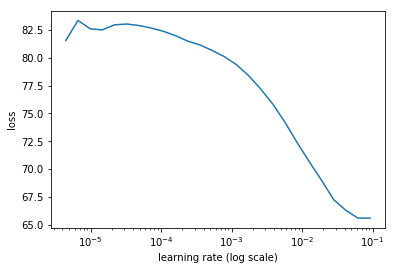

In [140]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [141]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      43.186253  33.360927 
    1      33.660089  28.751827                           
    2      29.49566   27.283592                           
    3      26.697973  26.545326                           
    4      24.504931  25.931739                           



[array([25.93174])]

In [142]:
learn.save('0')

In [143]:
learn.load('0')

### Testing

In [144]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [145]:
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [146]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [147]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

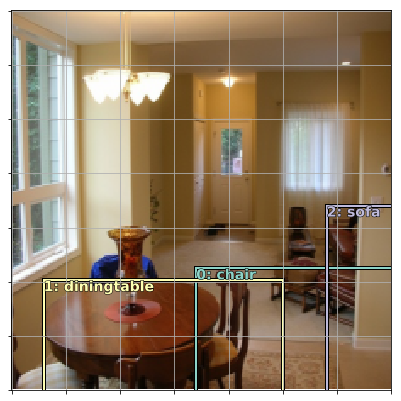

In [148]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

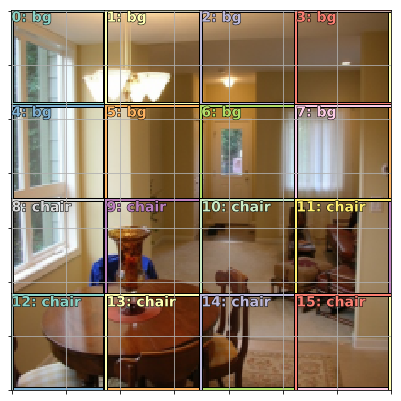

In [149]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [150]:
a_ic = actn_to_bb(b_bboxi, anchors)

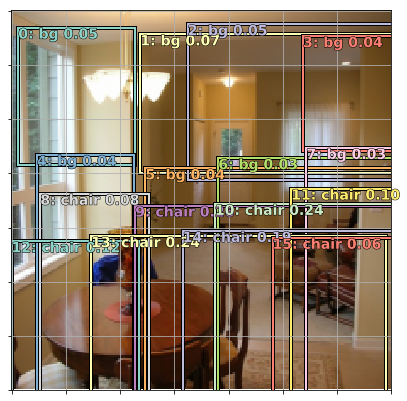

In [151]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [152]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [153]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [154]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

In [155]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx


 11
 13
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]

In [156]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

In [157]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

(Variable containing:
 1.00000e-02 *
   7.9766
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.9099
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

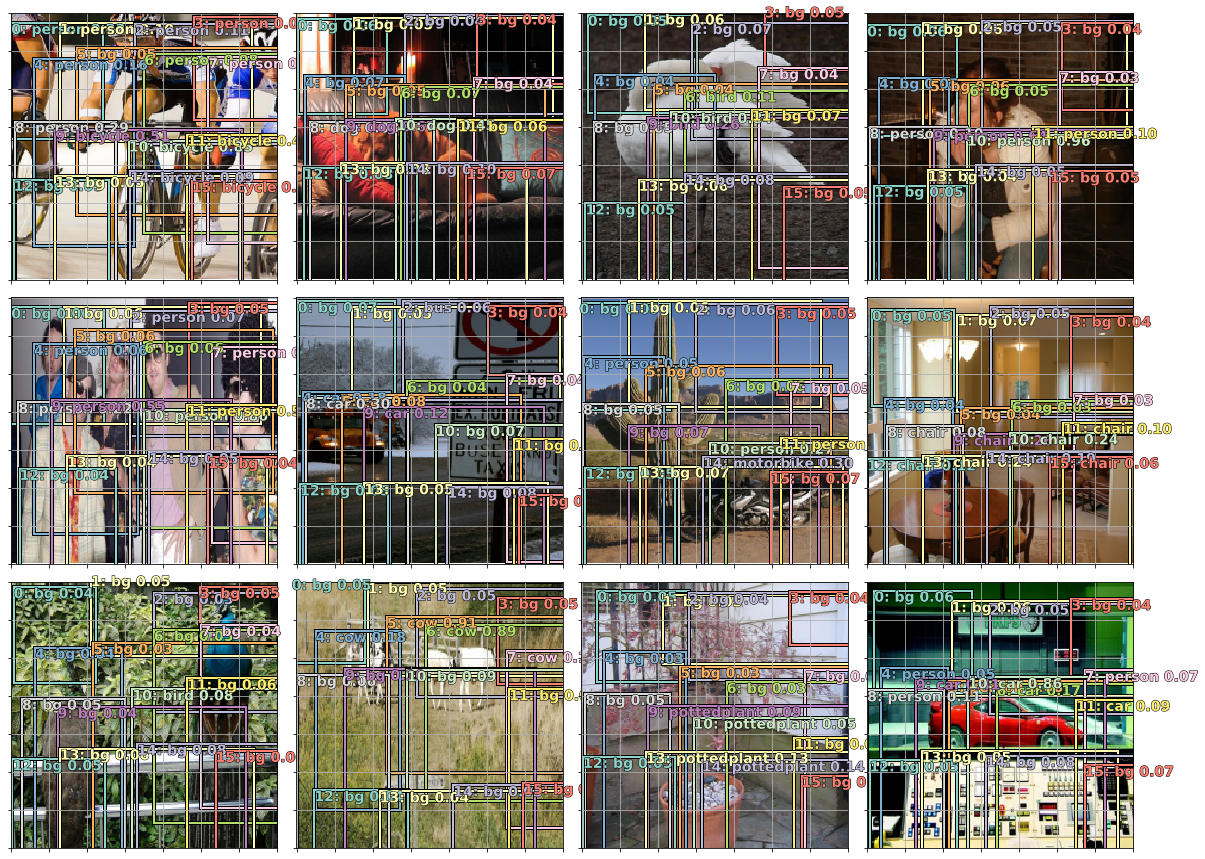

In [158]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

In [159]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [160]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [161]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [162]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [163]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

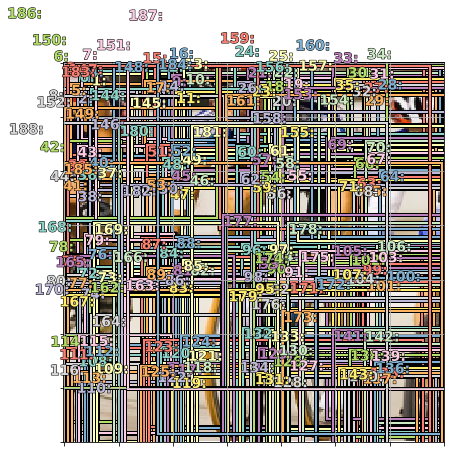

In [164]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

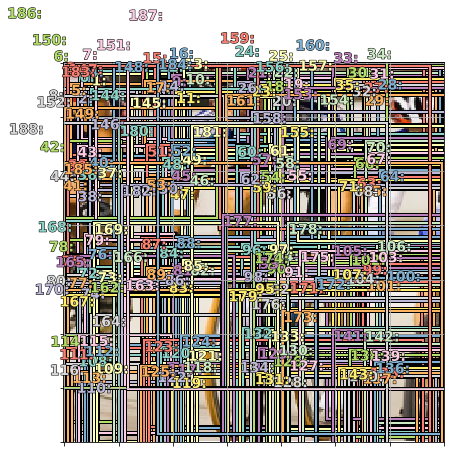

In [165]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

In [166]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [167]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [168]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(V(x))

In [169]:
batch[0].size(),batch[1].size()

(torch.Size([64, 189, 21]), torch.Size([64, 189, 4]))

In [170]:
ssd_loss(batch, y, True)


 0.5598
 0.7922
 0.3095
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.6075
 0.7035
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.7764
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7268
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5163
 0.4763
 0.3709
 0.4986
 0.2990
 0.0887
 0.1046
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3789
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5153
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.6215
 0.5742
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.4246
 0.5208
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3257
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.9734
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.4477
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7722
 0.5177
 0.6392
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.7384
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.4679
 0.8901
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.6597
 0.1221
[torch.cuda.FloatTensor of size 2 (GPU 0)]



Variable containing:
 332.2737
[torch.cuda.FloatTensor of size 1 (GPU 0)]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      295.462657 1388603.897



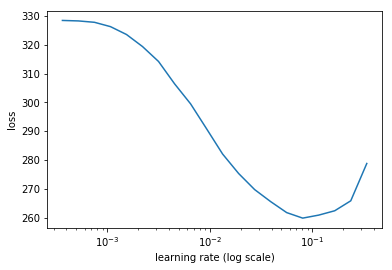

In [171]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [172]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      160.105376 132.147078
    1      126.748172 102.029603                         
    2      108.244467 93.65464                           
    3      95.974633  86.628128                           



[array([86.62813])]

In [173]:
learn.save('tmp')

In [174]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      91.297422  103.124529
    1      85.23062   85.276752                           
    2      77.97506   79.722703                           
    3      70.709613  76.416419                           



[array([76.41642])]

In [175]:
learn.save('prefocal')

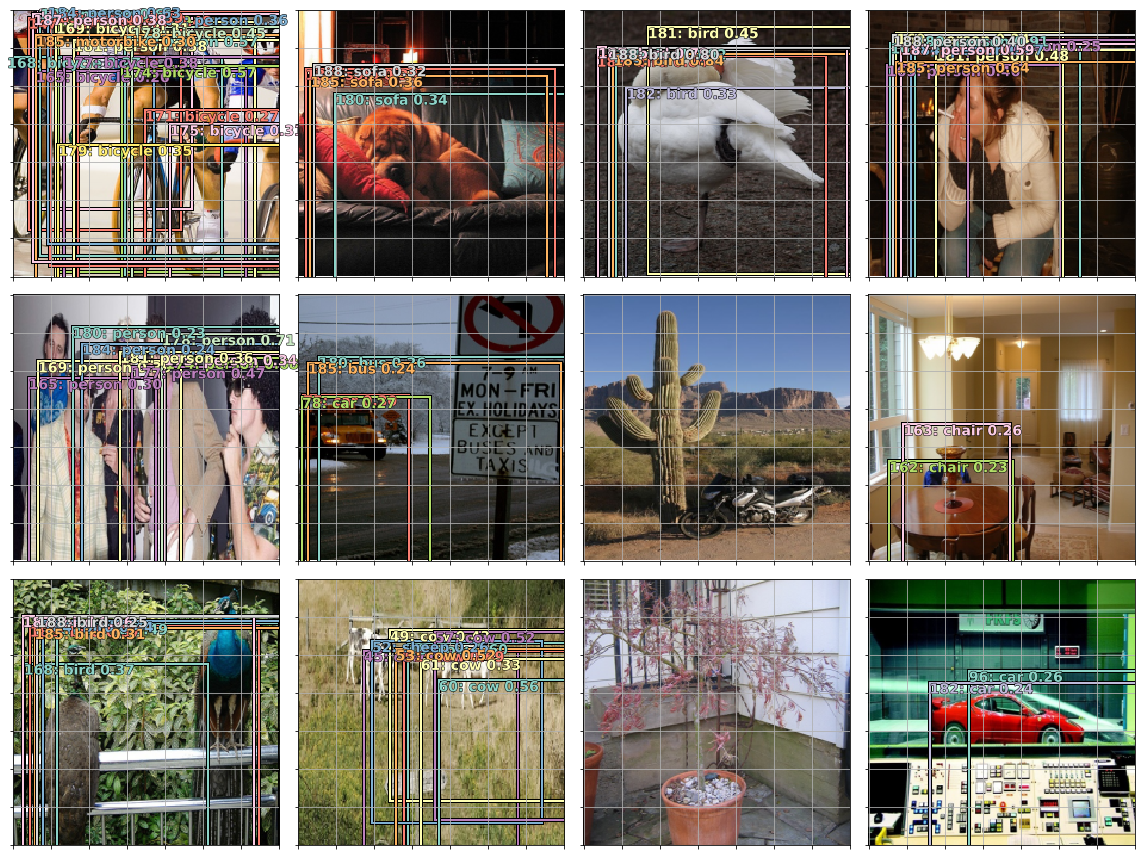

In [176]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
plt.tight_layout()

In [177]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [178]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [179]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)
ssd_loss(batch, y, True)


 0.5598
 0.7922
 0.3095
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.6075
 0.7035
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.7764
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7268
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5163
 0.4763
 0.3709
 0.4986
 0.2990
 0.0887
 0.1046
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3789
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5153
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.6215
 0.5742
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.4246
 0.5208
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3257
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.9734
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.4477
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7722
 0.5177
 0.6392
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.7384
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.4679
 0.8901
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.6597
 0.1221
[torch.cuda.FloatTensor of size 2 (GPU 0)]



Variable containing:
 21.1938
[torch.cuda.FloatTensor of size 1 (GPU 0)]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 30/32 [00:31<00:02,  1.05s/it, loss=374] 

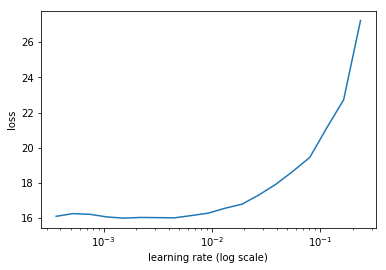

In [180]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

In [181]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

 12%|█▎        | 4/32 [00:06<00:48,  1.74s/it, loss=16.1]


Exception in thread Thread-37:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      18.662571  35.307348 
    1      20.688844  22.889168                           
    2      19.765368  19.636617                           
    3      18.498942  20.84365                            
    4      17.138058  17.730078                           
    5      15.92251   17.113066                           
    6      14.775225  16.832871                           
    7      13.826325  16.492516                           
    8      12.95454   16.368785                           
    9      12.18254   16.057196                           



[array([16.0572])]

In [ ]:
learn.save('fl0')

In [182]:
learn.load('f10')

FileNotFoundError: [Errno 2] No such file or directory: 'data/PASCAL_VOC/models/f10.h5'

In [183]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      11.206392  16.68824  
    1      11.273667  17.227646                           
    2      11.209588  16.723569                           
    3      10.936907  16.361699                           
    4      10.596502  16.608013                           
    5      10.253604  16.459079                           
    6      9.912358   16.405656                           
    7      9.555784   16.341696                           
    8      9.294141   16.172284                           
    9      9.035086   16.224042                           



[array([16.22404])]

In [185]:
learn.save('drop4')

In [186]:
learn.load('drop4')

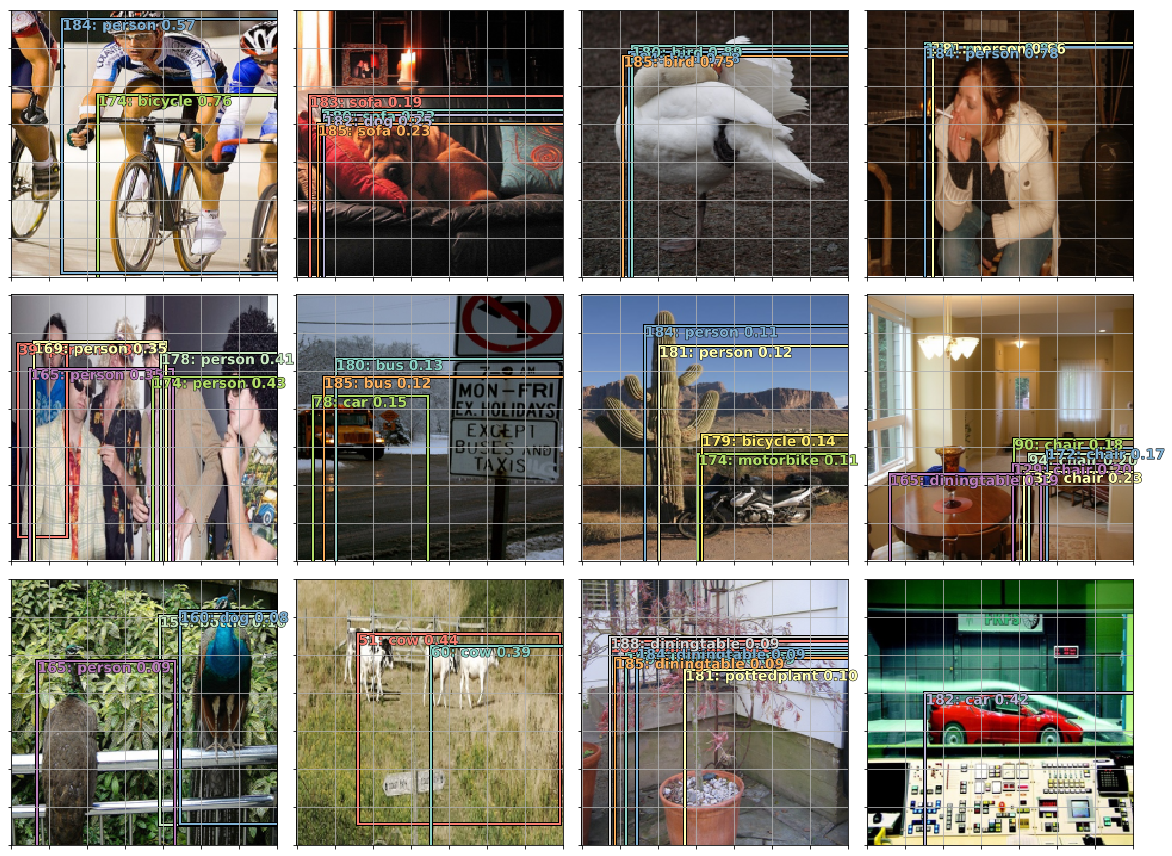

In [187]:
plot_results(0.75)

In [188]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [189]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [190]:
def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

ValueError: need at least one array to concatenate

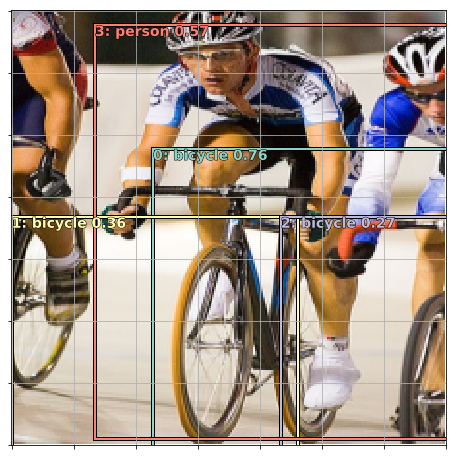

In [193]:
for i in range(12): show_nmf(i)